# Ozone AQI
 Model Fit - Weekly
Fitting Appropiate Model To data

__Setup Enviroment__

In [1]:
# Install Packages
import pandas as pd
import os, sys
import matplotlib.pyplot as plt

# Command Line
cwd_0 = os.getcwd()
print('Initial Directory: ', cwd_0)

# Set Up Envrioment
from utilites import setup_environment
setup_environment()
print(list(sys.path))
os.chdir(os.getenv("PYTHONPATH"))

# Settings
plt.style.use('fivethirtyeight')

Initial Directory:  /Users/nicholasbenelli/Workspace/GitHub-Ent/WAI/7-AirQuality-2/epa/notebooks/time-series/AQI-Ozone-TS
PYTHONPATH /Users/nicholasbenelli/Workspace/GitHub-Ent/WAI/7-AirQuality-2/.env
PYTHONPATH /Users/nicholasbenelli/Workspace/GitHub-Ent/WAI/7-AirQuality-2/.env
['/Users/nicholasbenelli/Workspace/GitHub-Ent/WAI/7-AirQuality-2/epa/notebooks/time-series/AQI-Ozone-TS', '/Users/nicholasbenelli/Workspace/GitHub-Ent/WAI/7-AirQuality-2/epa/notebooks/time-series/AQI-Ozone-TS/~/Workspace/GitHub-Ent/WAI/7-AirQuality-2', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python311.zip', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/lib-dynload', '', '/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages', '/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages', '/Users/nicholasbenelli/Workspace/GitHub-Ent/WAI/7-AirQuality-2/epa/notebooks/time-seri

In [2]:
# local packages
import epa

In [3]:
# Global Variables
plot_colors = epa.ts_methods.plot.colors

param_name = 'Ozone'

init_color = "#008fd5"

from pylab import rcParams
int_figsize = rcParams['figure.figsize']


## Explore Data
### Load Data

In [4]:
# Load Data
df_import = pd.read_csv("./epa/data/daily/O3.csv")
df_poll0 = df_import.copy()
df_poll0 = epa.data_utils.clean_epa_df(df_poll0)
df_poll0['datetime'] = pd.to_datetime(df_poll0['datetime'])
print(df_poll0.shape)
print(list(df_poll0.columns))
display(df_poll0.head(2))
#display(df_poll0.tail(3))

# Filter by county
county_list = list(df_poll0['county_code'].unique())
print("Number of Counties:", len(county_list))
print("County List:", county_list)

county_code = "037"

print("County:", county_code)
df_county0 = df_poll0.loc[df_poll0['county_code'] == county_code]
print("Shape:", df_county0.shape)
display(df_county0.tail(5))

(207207, 9)
['datetime', 'daily_meas', 'aqi', 'county_code', 'state_code', 'parameter_code', 'parameter', 'sample_duration', 'units_of_measure']


,datetime,daily_meas,aqi,county_code,state_code,parameter_code,parameter,sample_duration,units_of_measure
0,2012-01-01,0.018667,17.333333,001,06,44201,Ozone,Daily Max 8-hour Ozone Concentration,ppm
1,2012-01-02,0.015333,14.333333,001,06,44201,Ozone,Daily Max 8-hour Ozone Concentration,ppm


Number of Counties: 49
County List: ['001', '005', '007', '009', '011', '013', '017', '019', '021', '023', '025', '027', '029', '031', '033', '037', '039', '041', '043', '045', '047', '053', '055', '057', '059', '061', '065', '067', '069', '071', '073', '075', '077', '079', '081', '083', '085', '087', '089', '093', '095', '097', '099', '101', '103', '107', '109', '111', '113']
County: 037
Shape: (4318, 9)


,datetime,daily_meas,aqi,county_code,state_code,parameter_code,parameter,sample_duration,units_of_measure
67901,2023-11-03,0.054000,60.555556,037,06,44201,Ozone,Daily Max 8-hour Ozone Concentration,ppm
67902,2023-11-04,0.057833,72.111111,037,06,44201,Ozone,Daily Max 8-hour Ozone Concentration,ppm
67903,2023-11-05,0.064778,93.277778,037,06,44201,Ozone,Daily Max 8-hour Ozone Concentration,ppm
67904,2023-11-06,0.046444,47.555556,037,06,44201,Ozone,Daily Max 8-hour Ozone Concentration,ppm
67905,2023-11-07,0.041333,41.555556,037,06,44201,Ozone,Daily Max 8-hour Ozone Concentration,ppm


In [5]:
# Select Time Series
metric_study = 'aqi'
metric_um = 'AQI' #df_county0['units_of_measure'].iloc[0]
county_time_series = pd.Series(df_county0[metric_study].values, index=df_county0['datetime'], name= metric_study)

print(county_time_series.shape)
display(pd.DataFrame(county_time_series.describe()))
display(pd.DataFrame(county_time_series.head(5)))

(4318,)


,aqi
count,4318.000000
mean,50.075759
std,17.959526
min,11.600000
25%,37.622469
50%,45.594444
75%,59.312670
max,140.647059


,aqi
datetime,
2012-01-01,27.928571
2012-01-02,26.214286
2012-01-03,17.142857
2012-01-04,20.261905
2012-01-05,18.952381


In [6]:
# Interpolate daily dates
print('Daily')
print(county_time_series.index.min(),",", county_time_series.index.max())
dates = pd.date_range(county_time_series.index.min(), county_time_series.index.max())

daily_time_series = pd.Series(index=dates, name=county_time_series.name)
daily_time_series.index.name = county_time_series.index.name
daily_time_series.loc[:] = county_time_series.loc[:]
daily_time_series.name = county_time_series.name

#display(pd.DataFrame(daily_time_series.head(14)))

# Interpolate
daily_time_series.interpolate(method='linear')
daily_time_series = daily_time_series.interpolate(method='linear')
#display(pd.DataFrame(daily_time_series.head(14)))
print(daily_time_series.shape)

# Get Weekly Dates
print('Weekly')
df_weekly_time_seires = epa.ts_methods.aggregator.aggregate_weekly_data(
    daily_time_series, 
    metric_name= metric_study, datetime_name= 'datetime', 
    method='mean')

print(df_weekly_time_seires.shape)
#display(df_weekly_time_seires.head(5))
weekly_time_series = pd.Series(df_weekly_time_seires[metric_study])
#display(df_weekly_time_seires.head(5))


Daily
2012-01-01 00:00:00 , 2023-11-07 00:00:00
(4329,)
Weekly
(620, 1)


/var/folders/p3/zh2jf_6x0y50x6n2y7jhmznm0000gp/T/ipykernel_52625/784862156.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  daily_time_series = pd.Series(index=dates, name=county_time_series.name)


## Select Data

Data Used: Weekly

In [7]:
# Select Data to test
season = 52
data_select = weekly_time_series   # county_time_series, daily_time_series, weekly_time_series




### Test Train Split


In [8]:
# Variables
test_year_start = 2022
train_val_split = 0.8
n_splits = 3
use_normalized = False

In [9]:
time_series_data = data_select.copy()
df_counts_by_year = pd.DataFrame(time_series_data.index.year.value_counts().sort_index())
df_counts_by_year.columns = ['counts']
display(df_counts_by_year)

print("Median Count", df_counts_by_year.median())
#display(df_counts_by_year.describe())


period_suggested = int(df_counts_by_year['counts'].median())
print(f"Season : {season}, Suggested Season: {period_suggested}")
season = period_suggested

,counts
2011,1
2012,53
2013,52
2014,52
2015,52
2016,52
2017,52
2018,53
2019,52
2020,52


Median Count counts    52.0
dtype: float64
Season : 52, Suggested Season: 52


In [10]:


print("Count: ", len(time_series_data))
X = time_series_data.loc[time_series_data.index.year < test_year_start]
y = time_series_data.loc[~(time_series_data.index.year < test_year_start)]


print("X Shape: ", X.shape)
print("y Shape: ", y.shape)

print("test percent: ", round(len(y) / (len(y)+ len(X)), 2))

Count:  620
X Shape:  (523,)
y Shape:  (97,)
test percent:  0.16


In [11]:
# Normalize
from sklearn.preprocessing import StandardScaler

df_X = pd.DataFrame(X)
df_y = pd.DataFrame(y)

scaler = StandardScaler()
scaler = scaler.fit(df_X)

# Transform
X_norm_array = scaler.transform(df_X)
y_norm_array = scaler.transform(df_y)
#display(weekly_time_series_scaled_array)
df_X_norm = pd.DataFrame(X_norm_array, index=df_X.index, columns=df_X.columns)
df_y_norm = pd.DataFrame(y_norm_array, index=df_y.index, columns=df_y.columns)



X_ts_scaled = pd.Series(df_X_norm.iloc[:, 0])
y_ts_scaled = pd.Series(df_y_norm.iloc[:, 0])



print('X')
display(df_X_norm.tail(3))
display(df_X_norm.describe().round(2))


X


,aqi
datetime,
2021-12-13,-1.249386
2021-12-20,-1.177528
2021-12-27,-1.023978


,aqi
count,523.00
mean,0.00
std,1.00
min,-2.02
25%,-0.82
50%,-0.07
75%,0.69
max,3.92


In [12]:
if use_normalized:
    X_data = X_ts_scaled
    y_data = y_ts_scaled
else:
    X_data = X
    y_data = y

In [13]:
print("Use Normalization:", use_normalized)

Use Normalization: False


In [14]:

i_idx = int(round(len(X_data) * train_val_split, 0))

X_tr_data = X_data.iloc[:i_idx]
X_val_data = X_data.iloc[i_idx:]

print("Train Shape:", X_tr_data.shape, "Val Shape: ", X_val_data.shape)


Train Shape: (418,) Val Shape:  (105,)


Model Selection Code: 

```
import pmdarima as pm

model_sel1 = pm.auto_arima(
    X_tr_data, 
    start_p=2,d=0,start_q=2, 
    max_p=5,max_d=0,max_q=4, 
    start_P=0, D=0, start_Q=0, 
    max_P=3,max_D=0, max_Q=3, m=season, 
    seasonal=True, error_action='warn',trace=True, supress_warnings=True,stepwise=True, random_state=20,n_fits=50)
```

## Time Series forecasting 
[Statsmodel example notebooks](https://github.com/statsmodels/statsmodels/tree/master/examples/notebooks)

__K Folds Cross Validation__

In [15]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = n_splits)
print(tss)

train_idx_list = []
test_idx_list = []
for i, (train_index, test_index) in enumerate(tss.split(X_data)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    train_idx_list.append(train_index)
    test_idx_list.append(test_index)

print("Trian Test Idx Lengths:", len(train_idx_list), len(test_idx_list))

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None)
Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132]
  Test:  index=[133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168
 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186
 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204
 205 206 207 208 209 210 211 212 213 214 215 216 217 218 

------------------------
## Model Options
After doing some intial testing with the pmdarima package we are looking into the following models
Models to Try:

    SARIMA(2,0,2)x(3,1,0)[52]
    
    SARIMA(1,0,2)x(3,1,0)[52]


In [16]:
model_outcome_list = []
accuracy_list = []

#### Model #1: 

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [18]:
my_order = (2, 0, 2)
my_seasonal_order = (3, 1, 0, season)


my_order_str = str(my_order).replace(' ', '')
my_seasonal_order_str = str(my_seasonal_order[0:3]).replace(' ', '')

model_name = f"SARIMA{my_order_str}x{my_seasonal_order_str}[{my_seasonal_order[3]}]"


print(model_name)

SARIMA(2,0,2)x(3,1,0)[52]


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
k_fold_map = {
    'k' : [],
    'train_idx' : [],
    'val_idx' : [],
    'train_data' : [],
    'val_data' : [], 
    'ytrue' : [], 

    'model' : [], 
    'model_name' : [], 

    'pred_data' : [],
    'ypred' : [],
    'ci' : [], 
    'accuracy' : [], 
}

df_X = pd.DataFrame(X_data)
k = 0

for k in range(n_splits):
    print('----------------------------------------------')
    print(f"k={k}")

    # test, val data
    train_idx = train_idx_list[k]
    test_idx = test_idx_list[k]
    data_tr_k, data_val_k = df_X.iloc[train_idx, :], df_X.iloc[test_idx, :]
    y_true = data_val_k.values

    # Model Fit
    model = SARIMAX(data_tr_k, order=my_order, seasonal_order=my_seasonal_order).fit()
    k_model_name = f"{model_name}-k:{k}"

    data_pred_k = model.forecast(len(data_val_k))
    data_pred_k.index = data_val_k.index
    fcast = model.get_forecast(len(data_val_k))
    ci = fcast.conf_int()
    ci.index = data_val_k.index
    y_pred = data_pred_k.values

    acc_dict = epa.ts_methods.accuracy.find_prediction_acc(y_pred, y_true, print_result=False)
    acc_dict['aic'] = round(model.aic, 2)
    acc_dict['bic'] = round(model.bic, 2)
    acc_dict['llf'] = round(model.llf, 2)
    acc_dict['model'] = k_model_name
    acc_dict['k'] = k

    k_fold_map['k'].append(k)
    k_fold_map['train_idx'].append(train_idx)
    k_fold_map['val_idx'].append(test_idx)
    k_fold_map['train_data'].append(data_tr_k)
    k_fold_map['val_data'].append(data_val_k)
    k_fold_map['ytrue'].append(y_true)
    # Model
    k_fold_map['model'].append(model)
    k_fold_map['model_name'].append(k_model_name)
    # Predction
    k_fold_map['pred_data'].append(data_pred_k)
    k_fold_map['ypred'].append(y_pred)
    k_fold_map['ci'].append(ci)
    k_fold_map['accuracy'].append(acc_dict)




----------------------------------------------
k=0


/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24239D+00    |proj g|=  5.95826D-02

At iterate    5    f=  2.22995D+00    |proj g|=  7.13000D-03

At iterate   10    f=  2.22087D+00    |proj g|=  3.42095D-02

At iterate   15    f=  2.20723D+00    |proj g|=  2.20773D-03

At iterate   20    f=  2.20693D+00    |proj g|=  2.97156D-03

At iterate   25    f=  2.20669D+00    |proj g|=  2.35001D-03

At iterate   30    f=  2.20614D+00    |proj g|=  2.74740D-03

At iterate   35    f=  2.20594D+00    |proj g|=  1.94254D-03

At iterate   40    f=  2.20580D+00    |proj g|=  1.07281D-03

At iterate   45    f=  2.20572D+00    |proj g|=  4.47399D-04

At iterate   50    f=  2.20568D+00    |proj g|=  1.25149D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


----------------------------------------------
k=1


/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05160D+00    |proj g|=  1.40227D-01


 This problem is unconstrained.



At iterate    5    f=  3.01699D+00    |proj g|=  2.85214D-02

At iterate   10    f=  2.98390D+00    |proj g|=  4.60192D-03

At iterate   15    f=  2.98054D+00    |proj g|=  1.13885D-02

At iterate   20    f=  2.97786D+00    |proj g|=  7.50749D-03

At iterate   25    f=  2.97657D+00    |proj g|=  3.15458D-03

At iterate   30    f=  2.97652D+00    |proj g|=  4.65186D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     32     38      1     0     0   6.002D-06   2.977D+00
  F =   2.9765153212523314     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
----------------------------------------------
k=2


/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25816D+00    |proj g|=  1.29801D-01

At iterate    5    f=  3.23430D+00    |proj g|=  3.56375D-02

At iterate   10    f=  3.19555D+00    |proj g|=  1.66795D-02

At iterate   15    f=  3.19314D+00    |proj g|=  6.14076D-03

At iterate   20    f=  3.19217D+00    |proj g|=  2.19972D-03

At iterate   25    f=  3.19163D+00    |proj g|=  2.05569D-03

At iterate   30    f=  3.19153D+00    |proj g|=  1.74877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [20]:
accuracy_list.append(acc_dict)
acc_dict
pd.DataFrame([acc_dict]).T

,0
mape,0.136
mae,7.991
mpe,-0.045
rmse,12.258
corr,0.704
minmax,0.128
R_score,0.439
R2_corr,0.439
aic,2524.54
bic,2555.2


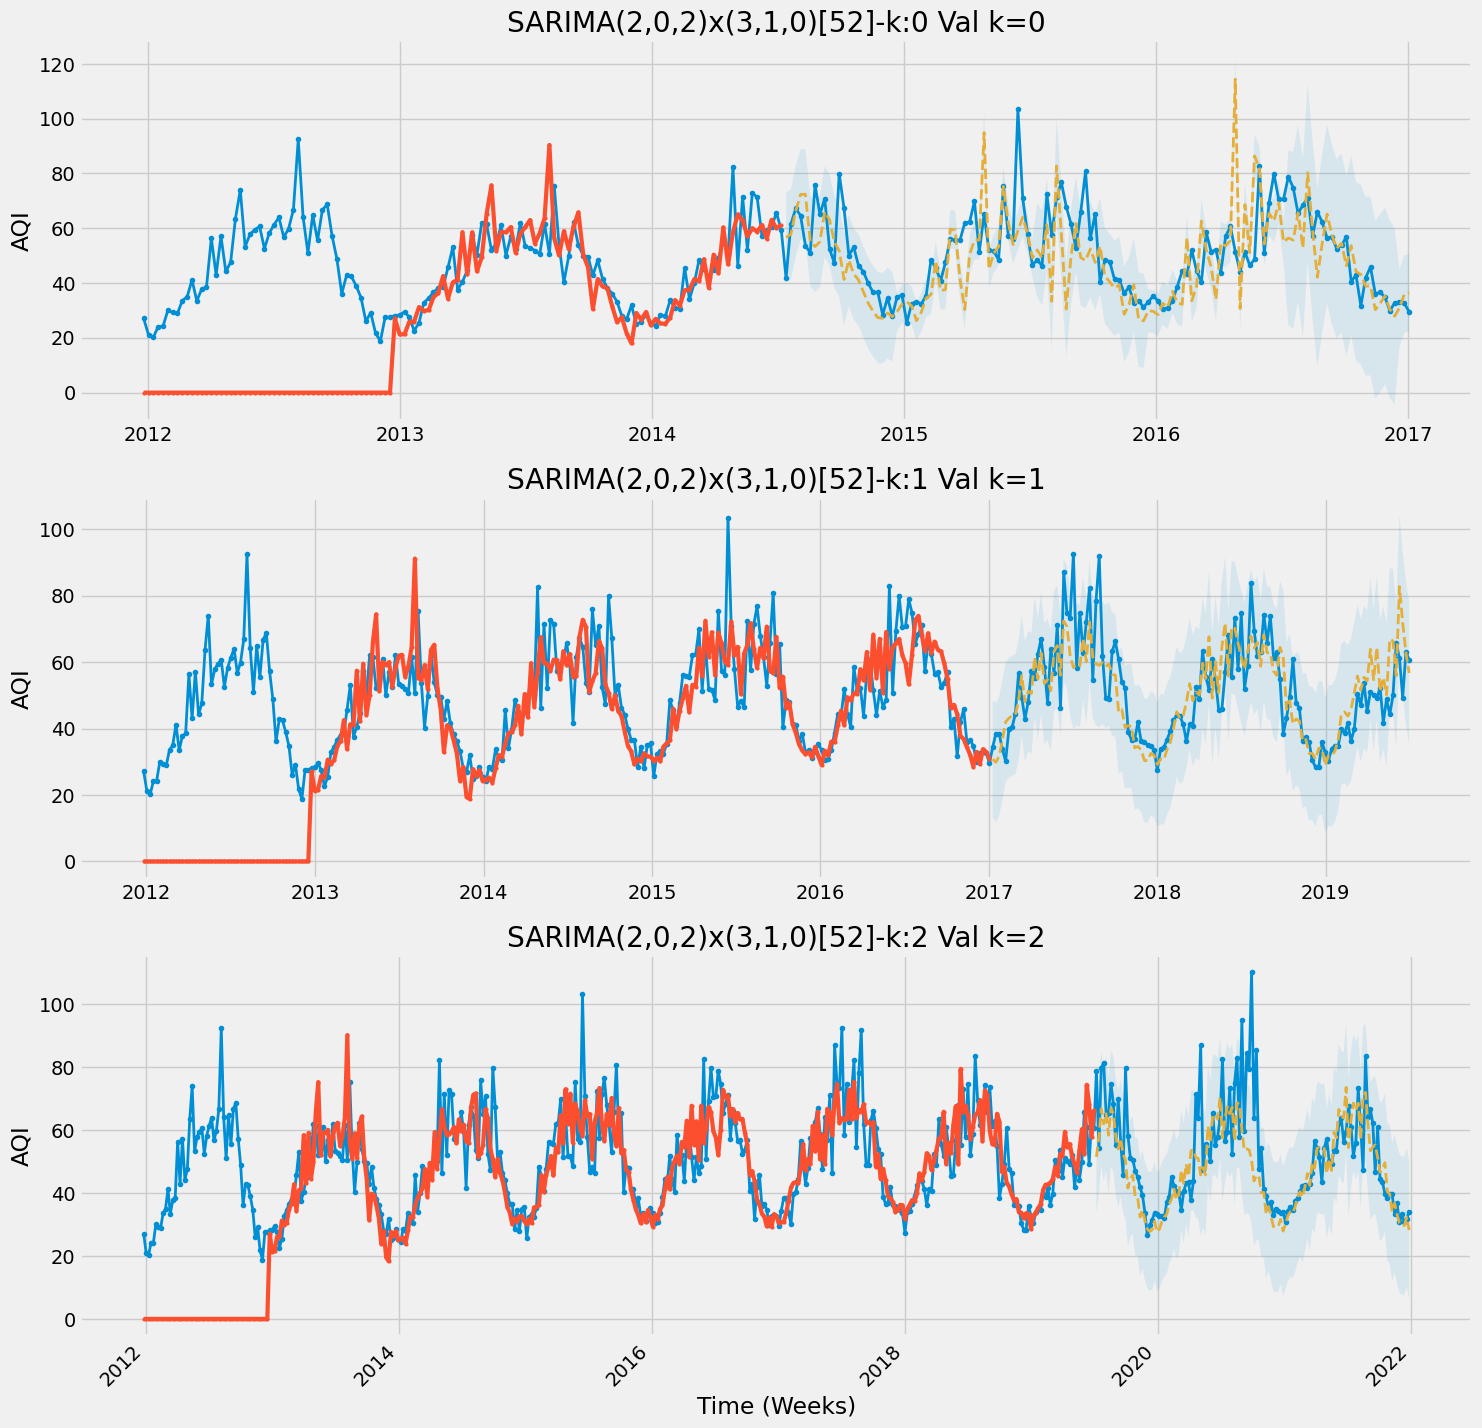

In [21]:
# Plot
line_pred_style = '--'

plt.figure(figsize=(16, 16))

for k in range(n_splits):
  plt.subplot(n_splits, 1, (k+1))
  plt.plot(pd.concat([k_fold_map['train_data'][k], k_fold_map['val_data'][k]], axis=0), marker='o', markersize=3, linewidth=2, label= 'true')

  # Model 
  model = k_fold_map['model'][k]
  model_name = k_fold_map['model_name'][k]

  plt.plot(model.fittedvalues, marker='o', markersize=2, linewidth=3,  label= f'{model_name} fitted')
  plt.plot(k_fold_map['pred_data'][k], line_pred_style, markersize=3, linewidth=2, label= f'{model_name} pred')

  ci = k_fold_map['ci'][k]

  plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.1, label = f'{model_name} pred ci')
  plt.title(f'{model_name} Val k={k}')
  if (k+1) == n_splits:
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Time (Weeks)')
  plt.ylabel(metric_um)

    
plt.show()

In [22]:
model_outcome_list.append(k_fold_map)
k_fold_map['accuracy'][-1]
pd.DataFrame([k_fold_map['accuracy'][-1]])

,mape,mae,mpe,rmse,corr,minmax,R_score,R2_corr,aic,bic,llf,model,k
0,0.136,7.991,-0.045,12.258,0.704,0.128,0.439,0.439,2524.54,2555.2,-1254.27,"SARIMA(2,0,2)x(3,1,0)[52]-k:2",2


#### R Squared Values 

In [23]:
# Correlated
#model.fittedvalues.name = 'Fitted'
df_true_v_fitted = pd.concat([data_tr_k, model.fittedvalues], axis=1).iloc[season:]
display(df_true_v_fitted.head(5))
display(df_true_v_fitted.corr() ** 2)
fitted_r2 = (df_true_v_fitted.corr() ** 2).iloc[1,0]
print(f"Model ({model_name}) Fitted R^2: {fitted_r2}")




df_true_v_forecast = pd.concat([data_val_k, data_pred_k], axis=1)
display(df_true_v_forecast.head(5))
display(df_true_v_forecast.corr() ** 2)
forecast_r2 = (df_true_v_forecast.corr() ** 2).iloc[1,0]
print(f"Model ({model_name}) Forecast R^2: {forecast_r2}")


,aqi,0
datetime,,
2012-12-24,28.117408,27.085712
2012-12-31,28.360711,21.288627
2013-01-07,29.493936,21.584835
2013-01-14,27.540755,26.110182
2013-01-21,22.572250,25.996072


,aqi,0
aqi,1.000000,0.600673
0,0.600673,1.000000


Model (SARIMA(2,0,2)x(3,1,0)[52]-k:2) Fitted R^2: 0.600673301939084


,aqi,predicted_mean
datetime,,
2019-07-08,78.666667,51.489293
2019-07-15,54.390476,57.724829
2019-07-22,79.609524,66.793355
2019-07-29,81.466667,61.990914
2019-08-05,64.952381,65.179913


,aqi,predicted_mean
aqi,1.00000,0.49527
predicted_mean,0.49527,1.00000


Model (SARIMA(2,0,2)x(3,1,0)[52]-k:2) Forecast R^2: 0.4952703704337048


#### PMDARIMA Model Param Check

In [24]:
import pmdarima as pm 

pm_model = pm.arima.ARIMA(order=my_order, seasonal_order=my_seasonal_order).fit(data_tr_k)

pm_model.summary()

/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  393
Model:             SARIMAX(2, 0, 2)x(3, 1, [], 52)   Log Likelihood               -1254.137
Date:                             Wed, 20 Dec 2023   AIC                           2526.274
Time:                                     18:27:42   BIC                           2560.761
Sample:                                 12-26-2011   HQIC                          2540.014
                                      - 07-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0577      0.154      0.376      0.707      -0.243       0.359
ar.L1          0.2634      0.194      1.354      0.176      -0.118       0.645
ar.L2          0.6926      0.189      3.674      0.000       0.323       1.062
ma.L1         -0.1133      0.175     -0.648      0.517      -0.456       0.229
ma.L2         -0.7104      0.149     -4.766      0.000      -1.003      -0.418
ar.S.L52      -0.6666      0.057    -11.610      0.000      -0.779      -0.554
ar.S.L104     -0.4401      0.066     -6.679      0.000      -0.569      -0.311
ar.S.L156     -0.2415      0.059     -4.069      0.000      -0.358      -0.125
sigma2        83.5760      5.304     15.757      0.000      73.180      93.972
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                84.93
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.45
Prob(H) (two-sided):                  0.17   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

___Residual Analysis Model 1___

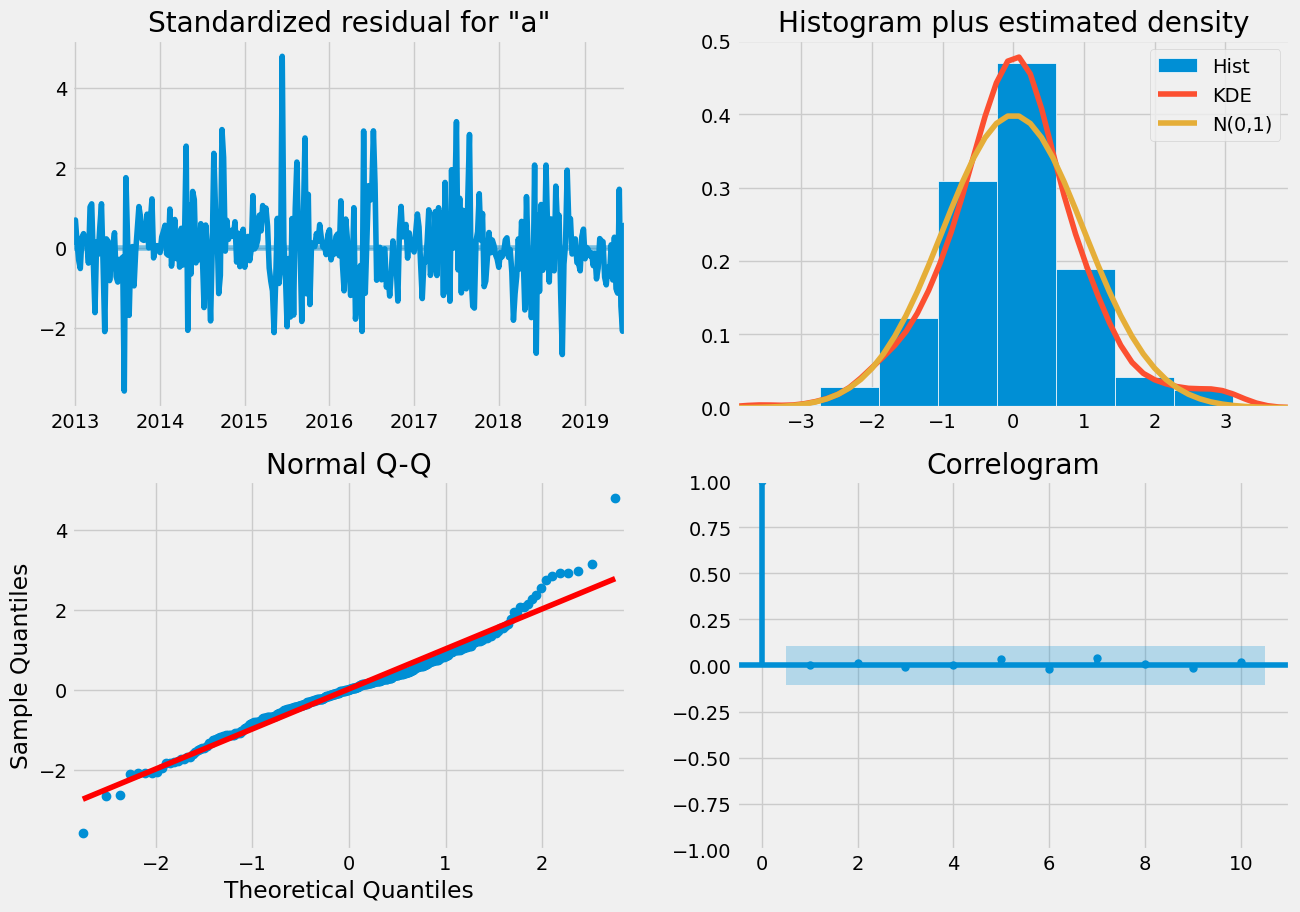

In [25]:
model.plot_diagnostics(figsize=(14, 10))
plt.show()

#### Model #2:
    ARIMA(1,0,2)(3,1,0)[52] 

In [26]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [27]:
my_order = (1, 0, 2)
my_seasonal_order = (3, 1, 0, season)


my_order_str = str(my_order).replace(' ', '')
my_seasonal_order_str = str(my_seasonal_order[0:3]).replace(' ', '')

model_name = f"SARIMA{my_order_str}x{my_seasonal_order_str}[{my_seasonal_order[3]}]"


print(model_name)

SARIMA(1,0,2)x(3,1,0)[52]


In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
k_fold_map = {
    'k' : [],
    'train_idx' : [],
    'val_idx' : [],
    'train_data' : [],
    'val_data' : [], 
    'ytrue' : [], 

    'model' : [], 
    'model_name' : [], 

    'pred_data' : [],
    'ypred' : [],
    'ci' : [], 
    'accuracy' : [], 
}

df_X = pd.DataFrame(X_data)
k = 0

for k in range(n_splits):
    print("------------------------------------")
    print(f"k={k}")

    # test, val data
    train_idx = train_idx_list[k]
    test_idx = test_idx_list[k]
    data_tr_k, data_val_k = df_X.iloc[train_idx, :], df_X.iloc[test_idx, :]
    y_true = data_val_k.values

    # Model Fit
    model = SARIMAX(data_tr_k, order=my_order, seasonal_order=my_seasonal_order).fit()
    k_model_name = f"{model_name}-k:{k}"

    data_pred_k = model.forecast(len(data_val_k))
    data_pred_k.index = data_val_k.index
    fcast = model.get_forecast(len(data_val_k))
    ci = fcast.conf_int()
    ci.index = data_val_k.index
    y_pred = data_pred_k.values

    acc_dict = epa.ts_methods.accuracy.find_prediction_acc(y_pred, y_true, print_result=False)
    acc_dict['aic'] = round(model.aic, 2)
    acc_dict['bic'] = round(model.bic, 2)
    acc_dict['llf'] = round(model.llf, 2)
    acc_dict['model'] = k_model_name
    acc_dict['k'] = k

    k_fold_map['k'].append(k)
    k_fold_map['train_idx'].append(train_idx)
    k_fold_map['val_idx'].append(test_idx)
    k_fold_map['train_data'].append(data_tr_k)
    k_fold_map['val_data'].append(data_val_k)
    k_fold_map['ytrue'].append(y_true)
    # Model
    k_fold_map['model'].append(model)
    k_fold_map['model_name'].append(k_model_name)
    # Predction
    k_fold_map['pred_data'].append(data_pred_k)
    k_fold_map['ypred'].append(y_pred)
    k_fold_map['ci'].append(ci)
    k_fold_map['accuracy'].append(acc_dict)




------------------------------------
k=0


/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28586D+00    |proj g|=  1.09179D-01


 This problem is unconstrained.



At iterate    5    f=  2.20619D+00    |proj g|=  1.71939D-02

At iterate   10    f=  2.19995D+00    |proj g|=  1.45095D-03

At iterate   15    f=  2.19921D+00    |proj g|=  1.19053D-03

At iterate   20    f=  2.19913D+00    |proj g|=  2.82422D-03

At iterate   25    f=  2.19885D+00    |proj g|=  1.17542D-03

At iterate   30    f=  2.19881D+00    |proj g|=  1.81860D-03

At iterate   35    f=  2.19877D+00    |proj g|=  9.90665D-04

At iterate   40    f=  2.19874D+00    |proj g|=  6.15241D-04

At iterate   45    f=  2.19872D+00    |proj g|=  5.81928D-04


/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.19871D+00    |proj g|=  6.95819D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   6.958D-04   2.199D+00
  F =   2.1987142979459691     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
------------------------------------
k=1


/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05433D+00    |proj g|=  1.13730D-01


 This problem is unconstrained.



At iterate    5    f=  3.01560D+00    |proj g|=  3.61646D-02

At iterate   10    f=  2.98967D+00    |proj g|=  6.84875D-03

At iterate   15    f=  2.98475D+00    |proj g|=  3.42906D-02

At iterate   20    f=  2.98060D+00    |proj g|=  7.23295D-03

At iterate   25    f=  2.97983D+00    |proj g|=  1.16602D-03

At iterate   30    f=  2.97983D+00    |proj g|=  1.65978D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     35      1     0     0   6.805D-06   2.980D+00
  F =   2.9798298861952950     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
------------------------------------
k=2


/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.25494D+00    |proj g|=  9.19684D-02

At iterate    5    f=  3.23568D+00    |proj g|=  3.46569D-02

At iterate   10    f=  3.21395D+00    |proj g|=  9.67478D-03

At iterate   15    f=  3.19625D+00    |proj g|=  7.70047D-03

At iterate   20    f=  3.19442D+00    |proj g|=  8.40814D-03

At iterate   25    f=  3.19422D+00    |proj g|=  2.24124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     32      1     0     0   

In [29]:
accuracy_list.append(acc_dict)
acc_dict
pd.DataFrame([acc_dict]).T

,0
mape,0.137
mae,8.019
mpe,-0.049
rmse,12.262
corr,0.706
minmax,0.129
R_score,0.439
R2_corr,0.439
aic,2524.66
bic,2551.48


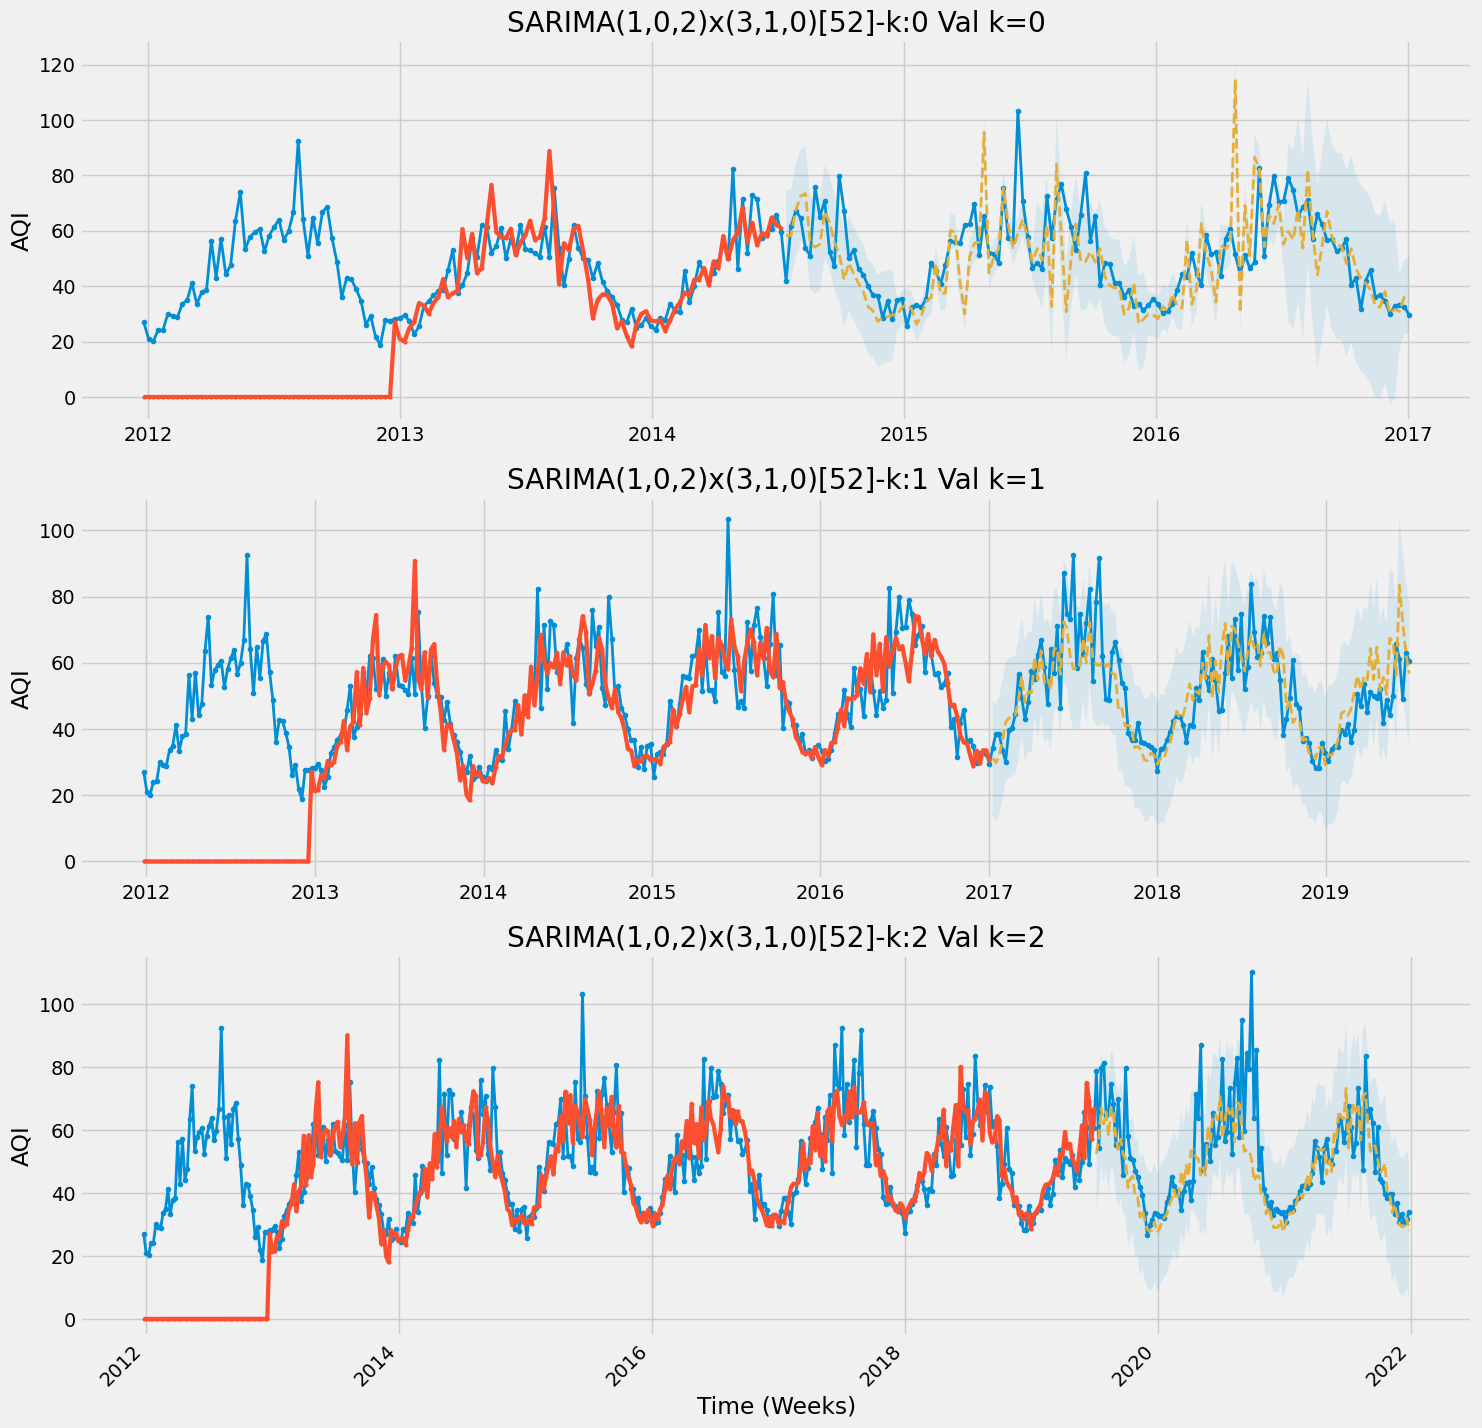

In [30]:
# Plot
line_pred_style = '--'

plt.figure(figsize=(16, 16))

for k in range(n_splits):
  plt.subplot(n_splits, 1, (k+1))
  plt.plot(
    pd.concat([k_fold_map['train_data'][k], k_fold_map['val_data'][k]], axis=0), 
    marker='o', markersize=3, linewidth=2, label= 'true'
    )

  # Model 
  model = k_fold_map['model'][k]
  model_name = k_fold_map['model_name'][k]

  plt.plot(model.fittedvalues, marker='o', markersize=2, linewidth=3,  label= f'{model_name} fitted')
  plt.plot(k_fold_map['pred_data'][k], line_pred_style, markersize=3, linewidth=2, label= f'{model_name} pred')

  ci = k_fold_map['ci'][k]

  plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.1, label = f'{model_name} pred ci')
  plt.title(f'{model_name} Val k={k}')
  if (k+1) == n_splits:
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Time (Weeks)')
  plt.ylabel(metric_um)

    
plt.show()

In [31]:
model_outcome_list.append(k_fold_map)
k_fold_map['accuracy'][-1]
pd.DataFrame([k_fold_map['accuracy'][-1]])

,mape,mae,mpe,rmse,corr,minmax,R_score,R2_corr,aic,bic,llf,model,k
0,0.137,8.019,-0.049,12.262,0.706,0.129,0.439,0.439,2524.66,2551.48,-1255.33,"SARIMA(1,0,2)x(3,1,0)[52]-k:2",2


__R Squared Values__

In [32]:
# Correlated
#model.fittedvalues.name = 'Fitted'
df_true_v_fitted = pd.concat([data_tr_k, model.fittedvalues], axis=1)
display(df_true_v_fitted.head(5))
display(df_true_v_fitted.corr() ** 2)
fitted_r2 = (df_true_v_fitted.corr() ** 2).iloc[1,0]
print(f"Model ({model_name}) Fitted R^2: {fitted_r2}")




df_true_v_forecast = pd.concat([data_val_k, data_pred_k], axis=1)
display(df_true_v_forecast.head(5))
display(df_true_v_forecast.corr() ** 2)
forecast_r2 = (df_true_v_forecast.corr() ** 2).iloc[1,0]
print(f"Model ({model_name}) Forecast R^2: {forecast_r2}")


,aqi,0
datetime,,
2011-12-26,27.071429,0.000000
2012-01-02,21.076531,0.000708
2012-01-09,20.190476,0.000975
2012-01-16,24.128571,0.001271
2012-01-23,24.200000,0.001669


,aqi,0
aqi,1.000000,0.251462
0,0.251462,1.000000


Model (SARIMA(1,0,2)x(3,1,0)[52]-k:2) Fitted R^2: 0.25146247366150215


,aqi,predicted_mean
datetime,,
2019-07-08,78.666667,52.475105
2019-07-15,54.390476,57.747498
2019-07-22,79.609524,67.051050
2019-07-29,81.466667,61.938098
2019-08-05,64.952381,65.807223


,aqi,predicted_mean
aqi,1.000000,0.498986
predicted_mean,0.498986,1.000000


Model (SARIMA(1,0,2)x(3,1,0)[52]-k:2) Forecast R^2: 0.49898563161636417


#### PMDARIMA Model Param Check

In [33]:
import pmdarima as pm 

pm_model = pm.arima.ARIMA(order=my_order, seasonal_order=my_seasonal_order).fit(data_tr_k)

pm_model.summary()

/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  393
Model:             SARIMAX(1, 0, 2)x(3, 1, [], 52)   Log Likelihood               -1255.218
Date:                             Wed, 20 Dec 2023   AIC                           2526.435
Time:                                     18:54:25   BIC                           2557.090
Sample:                                 12-26-2011   HQIC                          2538.649
                                      - 07-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0268      0.084      0.317      0.751      -0.139       0.192
ar.L1          0.9787      0.027     36.836      0.000       0.927       1.031
ma.L1         -0.8315      0.053    -15.641      0.000      -0.936      -0.727
ma.L2         -0.0761      0.050     -1.507      0.132      -0.175       0.023
ar.S.L52      -0.6829      0.058    -11.771      0.000      -0.797      -0.569
ar.S.L104     -0.4476      0.068     -6.603      0.000      -0.581      -0.315
ar.S.L156     -0.2368      0.060     -3.956      0.000      -0.354      -0.119
sigma2        83.9760      5.200     16.149      0.000      73.784      94.168
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                98.08
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.50
Prob(H) (two-sided):                  0.21   Kurtosis:                         5.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

__Residual Analysis:__ ___Model 2___

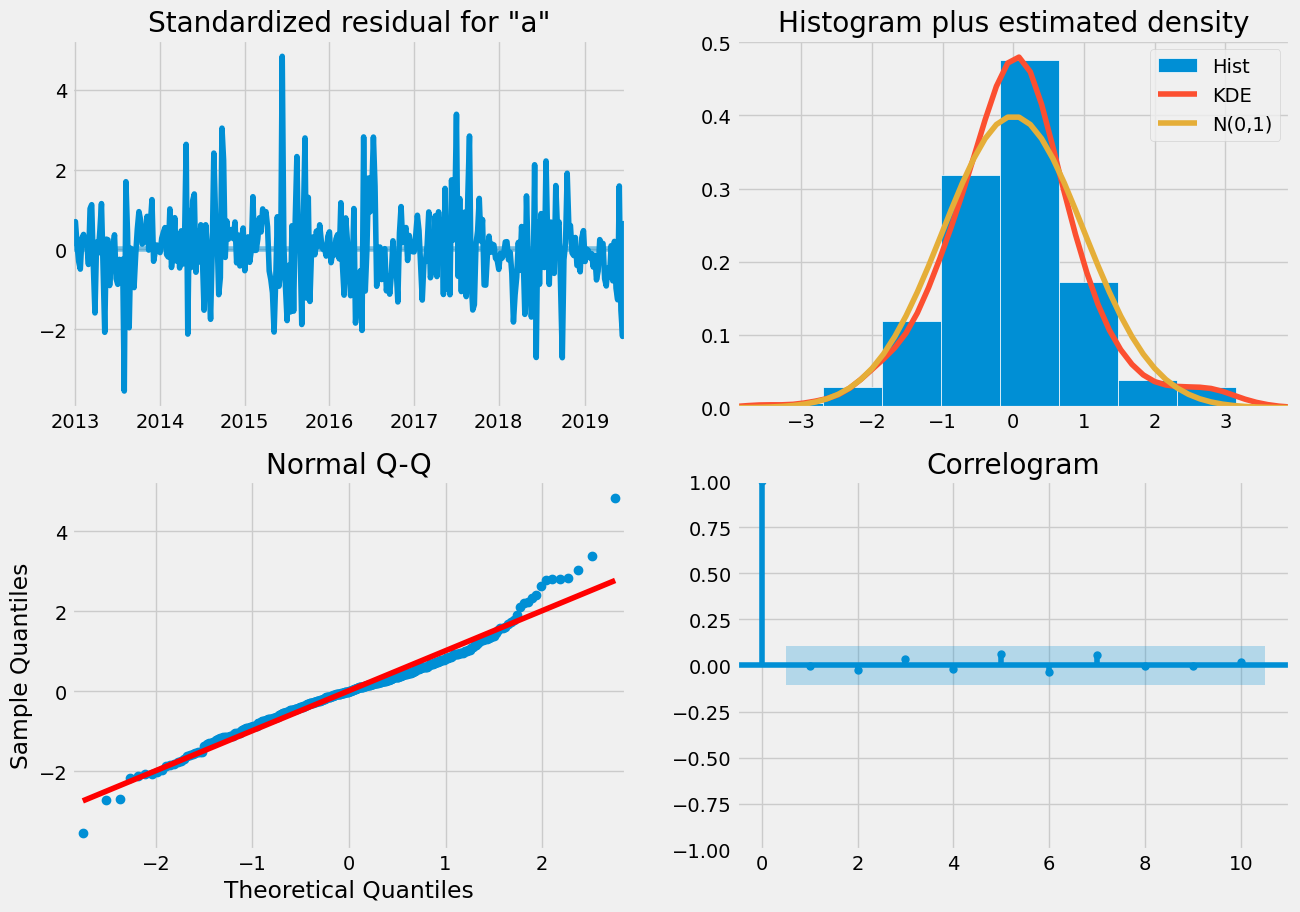

In [34]:
model.plot_diagnostics(figsize=(14, 10))
plt.show()

______
### Compare Accuracies


In [35]:
pd.DataFrame(accuracy_list)

,mape,mae,mpe,rmse,corr,minmax,R_score,R2_corr,aic,bic,llf,model,k
0,0.136,7.991,-0.045,12.258,0.704,0.128,0.439,0.439,2524.54,2555.20,-1254.27,"SARIMA(2,0,2)x(3,1,0)[52]-k:2",2
1,0.137,8.019,-0.049,12.262,0.706,0.129,0.439,0.439,2524.66,2551.48,-1255.33,"SARIMA(1,0,2)x(3,1,0)[52]-k:2",2


---------------------------
## Best Model
Pick the best model
- Use all training data and compare it to test data

In [36]:
# Model Parameters
my_order = (2, 0, 2)
my_seasonal_order  = (3, 1, 0, season)

my_order_str = str(my_order).replace(' ', '')
my_seasonal_order_str = str(my_seasonal_order[0:3]).replace(' ', '')

model_name = f"SARIMA{my_order_str}x{my_seasonal_order_str}[{my_seasonal_order[3]}]"

print(model_name)

SARIMA(2,0,2)x(3,1,0)[52]


In [37]:
k_fold_map = {
    'k' : [],
    'train_idx' : [],
    'val_idx' : [],
    'train_data' : [],
    'val_data' : [], 
    'ytrue' : [], 

    'model' : [], 
    'model_name' : [], 

    'pred_data' : [],
    'ypred' : [],
    'ci' : [], 
    'accuracy' : [], 
}

df_X = pd.DataFrame(X_data)
df_y = pd.DataFrame(y_data)
#k = 0




# train, test data
#train_idx = train_idx_list[k]
#test_idx = test_idx_list[k]
#data_tr_k, data_val_k = df_X.iloc[train_idx, :], df_X.iloc[test_idx, :]
y_true = df_y.values

# Model Fit
model = SARIMAX(df_X, order=my_order, seasonal_order=my_seasonal_order).fit()
#k_model_name = f"{model_name}"

data_pred = model.forecast(len(df_y))
fcast = model.get_forecast(len(df_y))
ci = fcast.conf_int()
y_pred = data_pred.values

acc_dict = epa.ts_methods.accuracy.find_prediction_acc(y_pred, y_true, print_result=False)
acc_dict['aic'] = round(model.aic, 2)
acc_dict['bic'] = round(model.bic, 2)
acc_dict['llf'] = round(model.llf, 2)
acc_dict['model'] = model_name
acc_dict['k'] = 'train'

k_fold_map['k'].append('train')
k_fold_map['train_idx'].append(None)
k_fold_map['val_idx'].append(None)
k_fold_map['train_data'].append(X_data)
k_fold_map['val_data'].append(y_data)
k_fold_map['ytrue'].append(y_true)
# Model
k_fold_map['model'].append(model)
k_fold_map['model_name'].append(k_model_name)
# Predction
k_fold_map['pred_data'].append(data_pred)
k_fold_map['ypred'].append(y_pred)
k_fold_map['ci'].append(ci)
k_fold_map['accuracy'].append(acc_dict)



/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40115D+00    |proj g|=  4.37001D-02


 This problem is unconstrained.



At iterate    5    f=  3.36637D+00    |proj g|=  4.18967D-02

At iterate   10    f=  3.35773D+00    |proj g|=  2.07316D-03

At iterate   15    f=  3.35742D+00    |proj g|=  8.55629D-04

At iterate   20    f=  3.35742D+00    |proj g|=  3.91945D-04

At iterate   25    f=  3.35738D+00    |proj g|=  2.38187D-03

At iterate   30    f=  3.35718D+00    |proj g|=  8.04628D-04

At iterate   35    f=  3.35715D+00    |proj g|=  4.41240D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     42      1     0     0   1.918D-05   3.357D+00
  F =   3.3571502662097368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [38]:
accuracy_list.append(acc_dict)
pd.DataFrame([acc_dict]).T

,0
mape,0.127
mae,6.649
mpe,0.034
rmse,9.077
corr,0.725
minmax,0.11
R_score,0.392
R2_corr,0.392
aic,3527.58
bic,3560.82


In [39]:
model_outcome_list.append(k_fold_map)
k_fold_map['accuracy'][-1]
pd.DataFrame([k_fold_map['accuracy'][-1]]).T

,0
mape,0.127
mae,6.649
mpe,0.034
rmse,9.077
corr,0.725
minmax,0.11
R_score,0.392
R2_corr,0.392
aic,3527.58
bic,3560.82


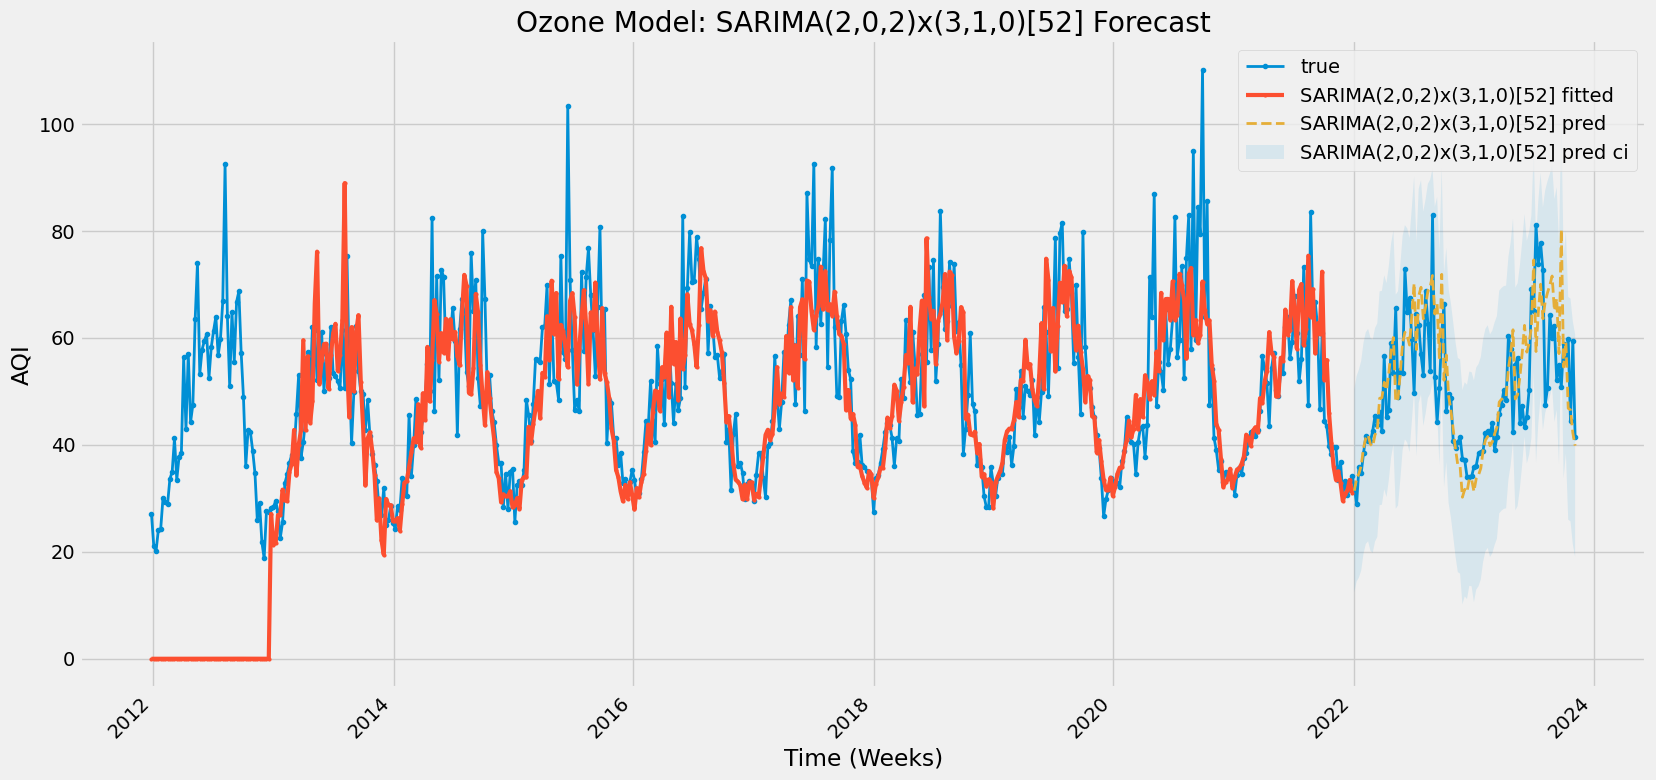

In [40]:
# Plot
line_pred_style = '--'

plt.figure(figsize=(18, 8))


plt.plot(pd.concat([X_data, y_data], axis=0), marker='o', markersize=3, linewidth=2, label= 'true')

# Model 
#model = k_fold_map['model'][k]
#model_name = k_fold_map['model_name'][k]

plt.plot(model.fittedvalues, marker='o', markersize=2, linewidth=3,  label= f'{model_name} fitted')
plt.plot(data_pred, line_pred_style, markersize=3, linewidth=2, label= f'{model_name} pred')


plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.1, label = f'{model_name} pred ci')
#plt.title(f'Model Comparison Cross Val k={k}')
if use_normalized:
    plt.title(f'{param_name} Model: {model_name} Forecast (Normalized)')
else:
    plt.title(f'{param_name} Model: {model_name} Forecast')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time (Weeks)')
plt.legend()
plt.ylabel(metric_um)

    
plt.show()

In [41]:
print("Accuracy:")
pd.DataFrame(accuracy_list)

Accuracy:


,mape,mae,mpe,rmse,corr,minmax,R_score,R2_corr,aic,bic,llf,model,k
0,0.136,7.991,-0.045,12.258,0.704,0.128,0.439,0.439,2524.54,2555.20,-1254.27,"SARIMA(2,0,2)x(3,1,0)[52]-k:2",2
1,0.137,8.019,-0.049,12.262,0.706,0.129,0.439,0.439,2524.66,2551.48,-1255.33,"SARIMA(1,0,2)x(3,1,0)[52]-k:2",2
2,0.127,6.649,0.034,9.077,0.725,0.110,0.392,0.392,3527.58,3560.82,-1755.79,"SARIMA(2,0,2)x(3,1,0)[52]",train


__Inverse Normalized Points__
    
If the data is normalized inverse the normalization to true points

In [42]:
if use_normalized:
    print("Inversing Normalization")
    # Fitted Values
    model_fit_vals_array = scaler.inverse_transform(pd.DataFrame(model.fittedvalues.copy()))
    model_fitted_vals_inv_series = pd.Series(model_fit_vals_array.flatten(), index= model.fittedvalues.index, name=model.fittedvalues.name)

    # Predicted Values
    data_pred_array = scaler.inverse_transform(pd.DataFrame(data_pred.copy()))
    data_pred_inv = pd.Series(data_pred_array.flatten(), index= data_pred.index, name=data_pred.name)

    # CI
    ci_inv = pd.DataFrame(scaler.inverse_transform(ci.copy()), index=ci.index, columns=ci.columns)

    # Assigned Names
    fitted_vals = model_fitted_vals_inv_series.copy()
    pred_vals = data_pred_inv.copy()
    ci_vals = ci_inv.copy()
else:
    print("No Inverse Needed")
    fitted_vals = model.fittedvalues.copy()
    pred_vals = data_pred.copy()
    ci_vals = ci.copy()
    #model_fitted_vals_inv_series = model.fittedvalues
    
    

No Inverse Needed


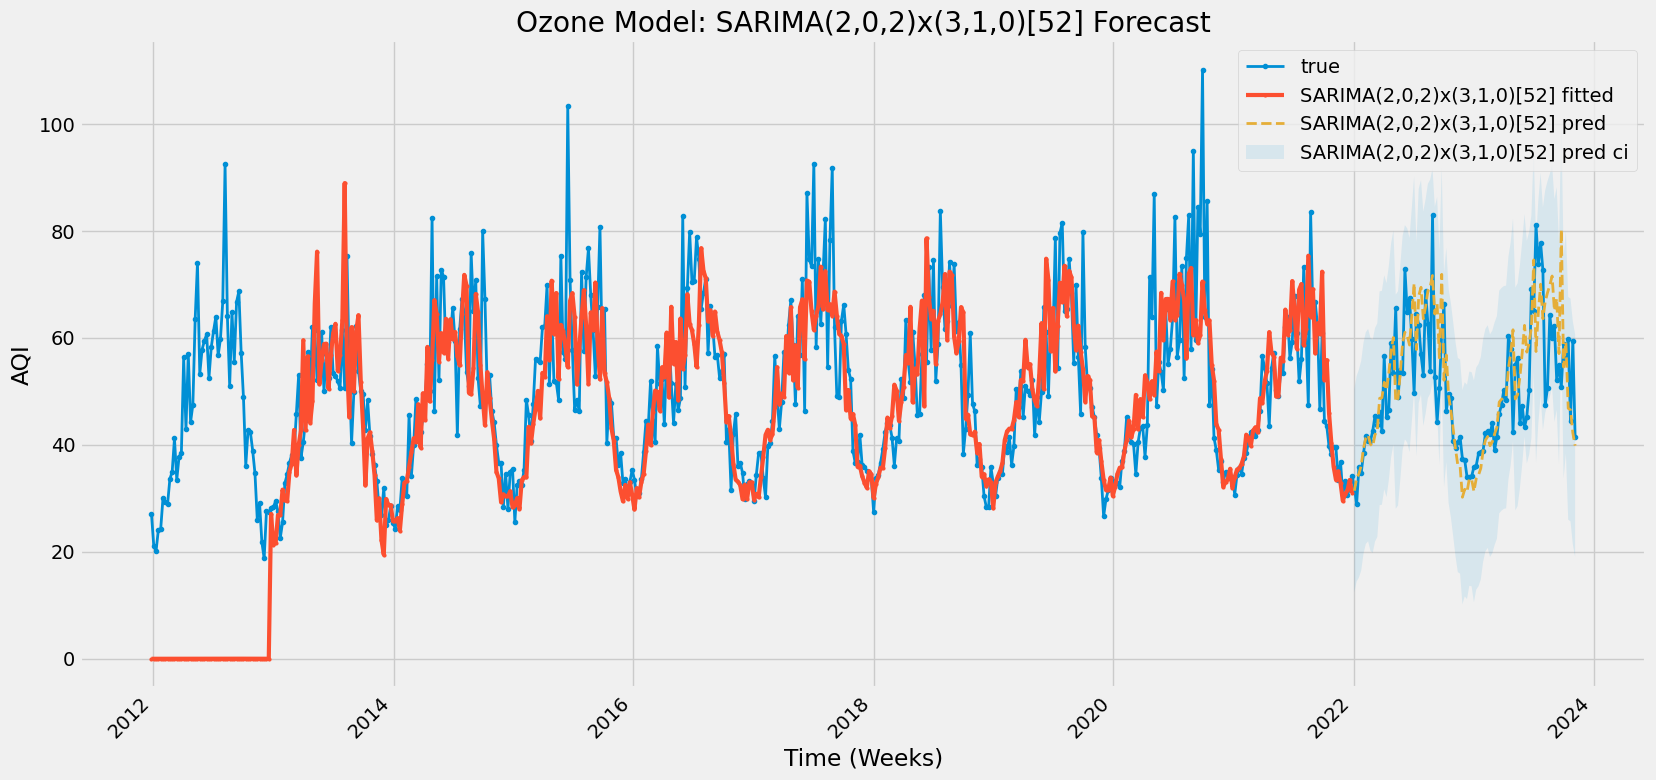

In [43]:
# Plot
line_pred_style = '--'

plt.figure(figsize=(18, 8))


plt.plot(pd.concat([X, y], axis=0), marker='o', markersize=3, linewidth=2, label= 'true')

# Model 
#model = k_fold_map['model'][k]
#model_name = k_fold_map['model_name'][k]

plt.plot(fitted_vals, marker='o', markersize=2, linewidth=3,  label= f'{model_name} fitted')
plt.plot(pred_vals, line_pred_style, markersize=3, linewidth=2, label= f'{model_name} pred')


plt.fill_between(ci_vals.index, ci_vals.iloc[:, 0], ci_vals.iloc[:, 1], alpha=0.1, label = f'{model_name} pred ci')
#plt.title(f'Model Comparison Cross Val k={k}')
plt.title(f'{param_name} Model: {model_name} Forecast')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time (Weeks)')
plt.legend()
plt.ylabel(metric_um)

    
plt.show()

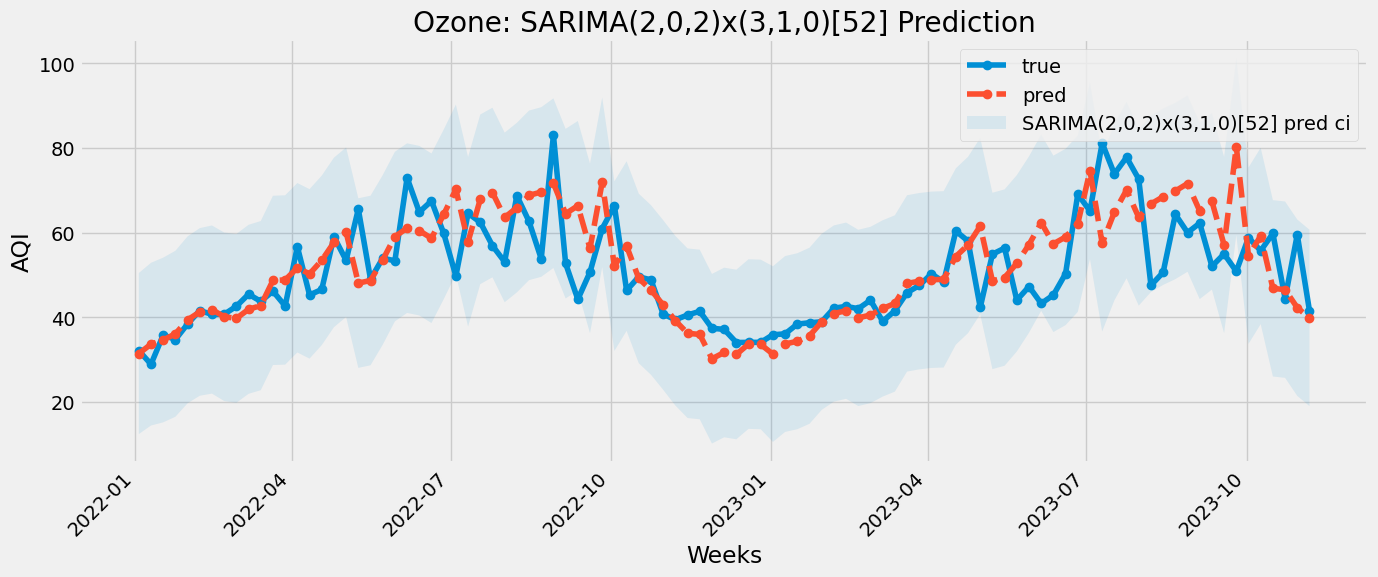

In [44]:
# Forecast vs y true

plt.figure(figsize=(14, 6))
plt.plot(pd.concat([y], axis=0), marker='o', label= 'true')
#plt.plot(model.fittedvalues, marker='o', label= 'fitted')
plt.plot(data_pred, line_pred_style, marker='o', label= 'pred')
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], alpha=0.1, label = f'{model_name} pred ci')
#plt.fill_between(ci.index, ci['lower cases'], ci['upper cases'], color='blue', alpha=0.1, label = f'pred ci')
plt.title(f'{param_name}: {model_name} Prediction')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Weeks')
plt.ylabel(metric_um)
plt.legend()
plt.tight_layout()
plt.show()

In [45]:
pd.DataFrame([acc_dict]).T

,0
mape,0.127
mae,6.649
mpe,0.034
rmse,9.077
corr,0.725
minmax,0.11
R_score,0.392
R2_corr,0.392
aic,3527.58
bic,3560.82


__R Squared Values__

In [46]:
# Correlated
#model.fittedvalues.name = 'Fitted'
df_true_v_fitted = pd.concat([X_data, model.fittedvalues], axis=1).iloc[season:]
display(df_true_v_fitted.head(3))

display(df_true_v_fitted.corr() ** 2)
fitted_r2 = (df_true_v_fitted.corr() ** 2).iloc[1,0]
print(f"Model ({model_name}) Fitted R^2: {fitted_r2}")



df_true_v_forecast = pd.concat([y_data, pred_vals], axis=1)
display(df_true_v_forecast.head(3))
display(df_true_v_forecast.corr() ** 2)
forecast_r2 = (df_true_v_forecast.corr() ** 2).iloc[1,0]
print(f"Model ({model_name}) Forecast R^2: {forecast_r2}")


print('\n\n')
print(f"Model ({model_name}) Fitted R^2:\t {fitted_r2}")
print(f"Model ({model_name}) Forecast R^2:\t {forecast_r2}")


,aqi,0
datetime,,
2012-12-24,28.117408,27.074776
2012-12-31,28.360711,21.306065
2013-01-07,29.493936,21.683280


,aqi,0
aqi,1.000000,0.582072
0,0.582072,1.000000


Model (SARIMA(2,0,2)x(3,1,0)[52]) Fitted R^2: 0.5820715504344504


,aqi,predicted_mean
2022-01-03,32.109244,31.426891
2022-01-10,28.903361,33.648793
2022-01-17,35.819328,34.631723


,aqi,predicted_mean
aqi,1.000000,0.526134
predicted_mean,0.526134,1.000000


Model (SARIMA(2,0,2)x(3,1,0)[52]) Forecast R^2: 0.5261339360242818



Model (SARIMA(2,0,2)x(3,1,0)[52]) Fitted R^2:	 0.5820715504344504
Model (SARIMA(2,0,2)x(3,1,0)[52]) Forecast R^2:	 0.5261339360242818


__PMDARIMA Model Param Check__

In [47]:
import pmdarima as pm 

pm_model = pm.arima.ARIMA(order=my_order, seasonal_order=my_seasonal_order).fit(data_tr_k)

pm_model.summary()

/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nicholasbenelli/Library/Python/3.11/lib/python/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  393
Model:             SARIMAX(2, 0, 2)x(3, 1, [], 52)   Log Likelihood               -1254.137
Date:                             Wed, 20 Dec 2023   AIC                           2526.274
Time:                                     19:01:26   BIC                           2560.761
Sample:                                 12-26-2011   HQIC                          2540.014
                                      - 07-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0577      0.154      0.376      0.707      -0.243       0.359
ar.L1          0.2634      0.194      1.354      0.176      -0.118       0.645
ar.L2          0.6926      0.189      3.674      0.000       0.323       1.062
ma.L1         -0.1133      0.175     -0.648      0.517      -0.456       0.229
ma.L2         -0.7104      0.149     -4.766      0.000      -1.003      -0.418
ar.S.L52      -0.6666      0.057    -11.610      0.000      -0.779      -0.554
ar.S.L104     -0.4401      0.066     -6.679      0.000      -0.569      -0.311
ar.S.L156     -0.2415      0.059     -4.069      0.000      -0.358      -0.125
sigma2        83.5760      5.304     15.757      0.000      73.180      93.972
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                84.93
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             0.45
Prob(H) (two-sided):                  0.17   Kurtosis:                         5.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Training Data Resiudal Analysis

In [48]:
print(model_name)
display(model.summary())

SARIMA(2,0,2)x(3,1,0)[52]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                 aqi   No. Observations:                  523
Model:             SARIMAX(2, 0, 2)x(3, 1, [], 52)   Log Likelihood               -1755.790
Date:                             Wed, 20 Dec 2023   AIC                           3527.579
Time:                                     19:01:26   BIC                           3560.818
Sample:                                 12-26-2011   HQIC                          3540.655
                                      - 12-27-2021                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5866      1.297      0.452      0.651      -1.955       3.129
ar.L2          0.2342      1.158      0.202      0.840      -2.036       2.504
ma.L1         -0.4418      1.301     -0.340      0.734      -2.991       2.107
ma.L2         -0.1609      0.962     -0.167      0.867      -2.046       1.724
ar.S.L52      -0.7150      0.045    -15.767      0.000      -0.804      -0.626
ar.S.L104     -0.4755      0.057     -8.300      0.000      -0.588      -0.363
ar.S.L156     -0.2360      0.051     -4.614      0.000      -0.336      -0.136
sigma2        94.1159      4.201     22.404      0.000      85.882     102.349
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               193.80
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             0.78
Prob(H) (two-sided):                  0.32   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""


SARIMA(2,0,2)x(3,1,0)[52]


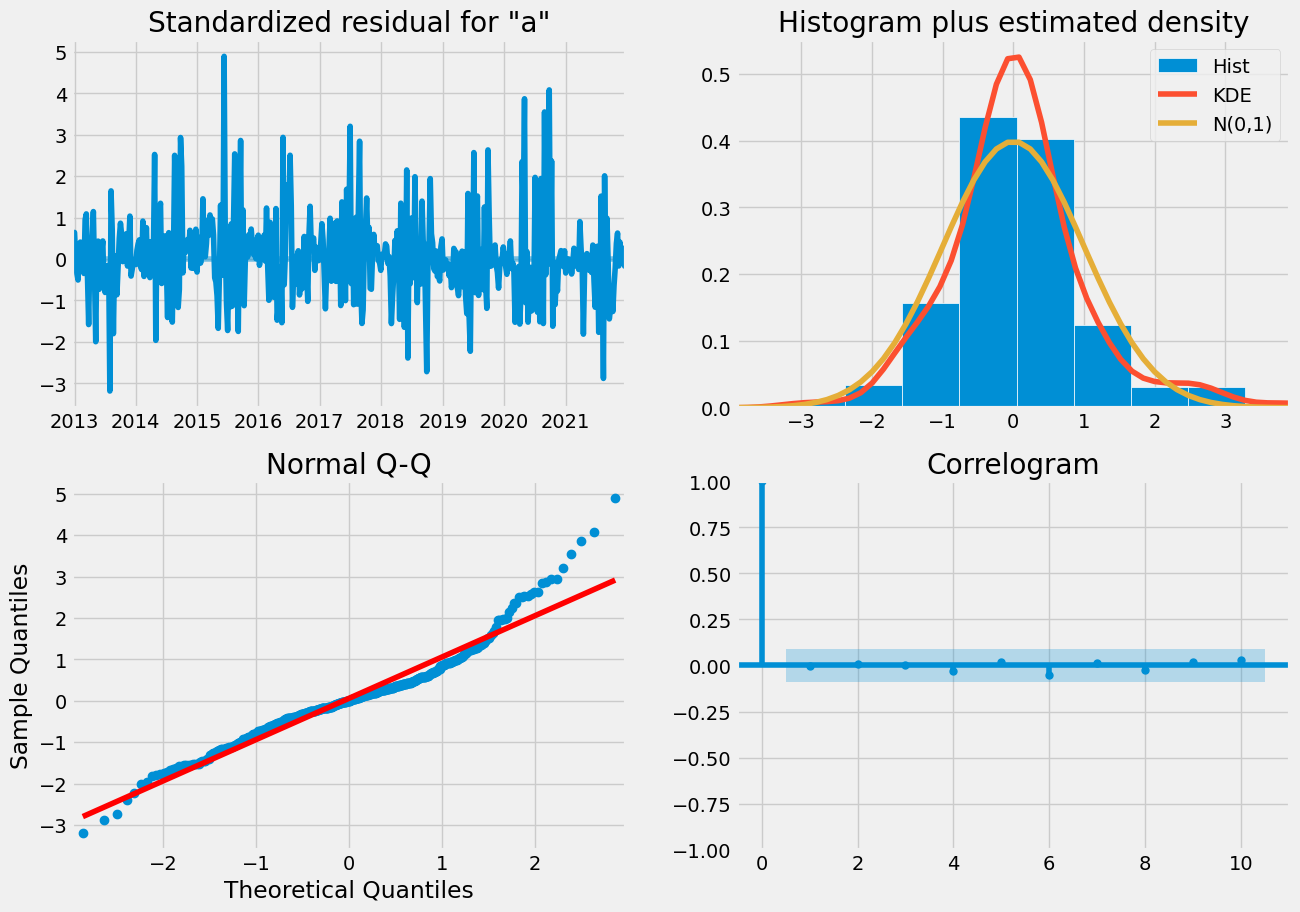

In [49]:
print(f'\n{model_name}')
model.plot_diagnostics(figsize=(14, 10))
plt.show()

,0
count,471.000000
mean,0.604276
std,10.015749
min,-38.393337
25%,-4.552709
50%,-0.025935
75%,4.737273
max,48.850415


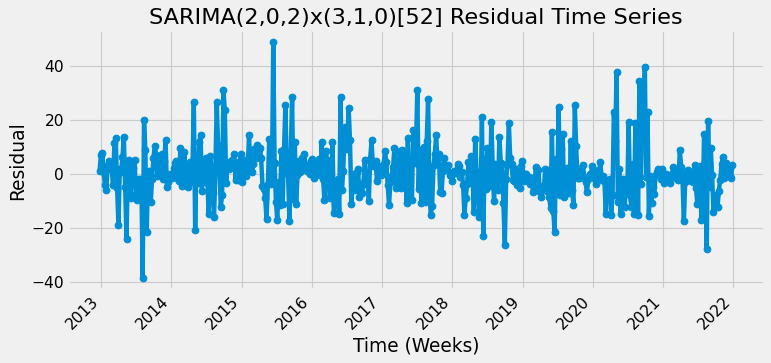

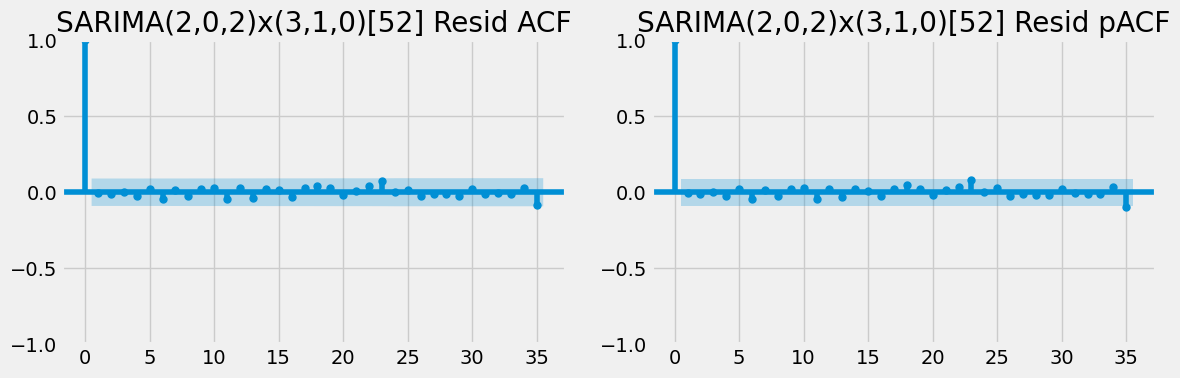

In [50]:
import statsmodels.api as sm

if my_seasonal_order[1] > 0:
    model_residuals = model.resid[(season * my_seasonal_order[1]):]
else:
    model_residuals = model.resid


df_model_residuals  = pd.DataFrame(model_residuals)
display(df_model_residuals.describe())

#df_model_residuals.plot()
#df_model_residuals.plot(kind='kde')
#plt.title(f'ARIMA{pdqParmas_list[inc]} Residuals')
#plt.show()

# Plot Resiudals
ts_fig_size = (10, 4)
acf_pacf_fig_size = (12,4)

#Plot Time Series
plt.figure(figsize= ts_fig_size, dpi=80)
plt.plot( df_model_residuals, marker='o')
plt.title(f'{model_name} Residual Time Series')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time (Weeks)')
plt.ylabel('Residual')
plt.show()


# acf pacf plts
fig, ax = plt.subplots(1,2,figsize= acf_pacf_fig_size)
# acf
sm.graphics.tsa.plot_acf(df_model_residuals.values.squeeze(), lags=35, ax=ax[0], title=f'{model_name} Resid ACF')
# pacf
sm.graphics.tsa.plot_pacf(df_model_residuals, lags=35, ax=ax[1], title=f'{model_name} Resid pACF') 
plt.tight_layout()
plt.show()

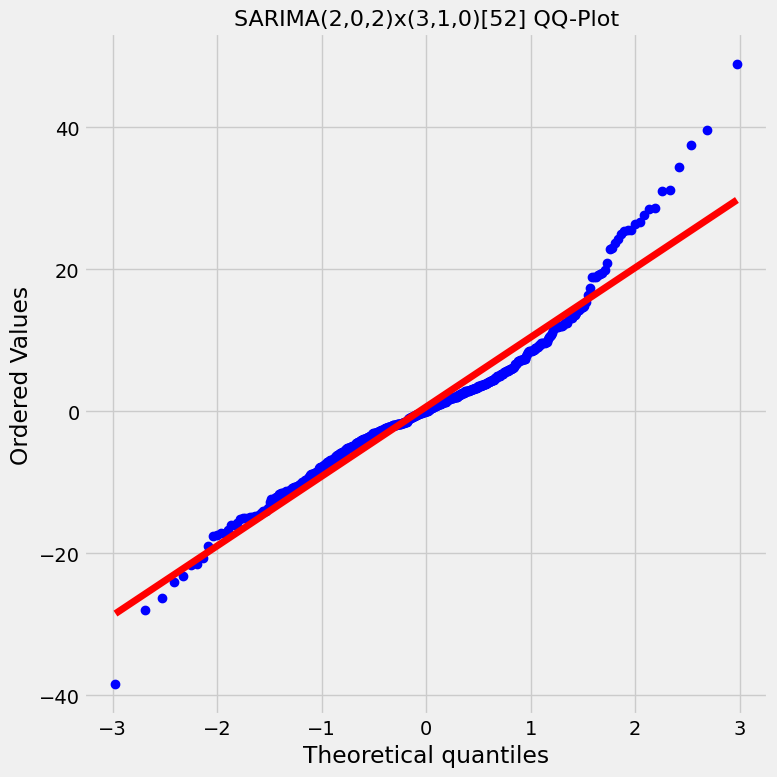



SARIMA(2,0,2)x(3,1,0)[52]
Shapiro-Wilk Test:
ShapiroResult(statistic=0.8223319053649902, pvalue=1.2573347101425576e-23)
p-value: 0.0. The null-hypothesis can be rejected. The data is not normally distributed.


ShapiroResult(statistic=0.8223319053649902, pvalue=1.2573347101425576e-23)

In [51]:
import scipy.stats as stats
fig = plt.figure(figsize = (8, 8))

ax = fig.add_subplot(1,1, 1)
res = stats.probplot(model_residuals, plot=plt)


#ax.get_lines()[0].set_marker('o')
#ax.get_lines()[0].set_markerfacecolor(line_color_list[inc])
#ax.get_lines()[0].set_markersize(4)

ax.get_lines()[1].set_linewidth(5)
plt.title(f'{model_name} QQ-Plot', fontsize=16)
plt.tight_layout()
plt.show()


print(f'\n\n{model_name}')
epa.ts_methods.shapiro_wilk_test(model.resid)





SARIMA(2,0,2)x(3,1,0)[52]


,lb_stat,lb_pvalue
30,11.875242,0.998733


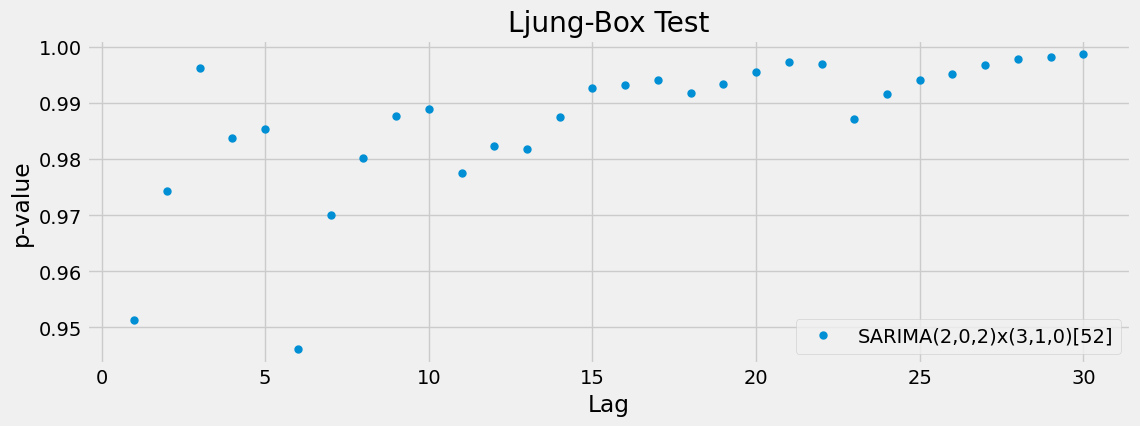

In [52]:

#Ljung Box Test

fig = plt.figure(figsize = (12, 4))
print('\n\n')
print(f'{model_name}')
lbt_array = sm.stats.acorr_ljungbox(pd.DataFrame(model_residuals), lags=30)
display(lbt_array.tail(1))

#plt.plot(lbt_array.lb_pvalue, marker='o', markersize=5, linewidth=0)
plt.plot(lbt_array.lb_pvalue, marker='o', markersize=5, linewidth=0, label= f'{model_name}')
plt.xlabel('Lag')
plt.ylabel('p-value')
plt.title(f'Ljung-Box Test')
plt.legend()
plt.show()
     

/var/folders/p3/zh2jf_6x0y50x6n2y7jhmznm0000gp/T/ipykernel_52625/586764509.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ar_std_residuals) # you may select the no. of bins


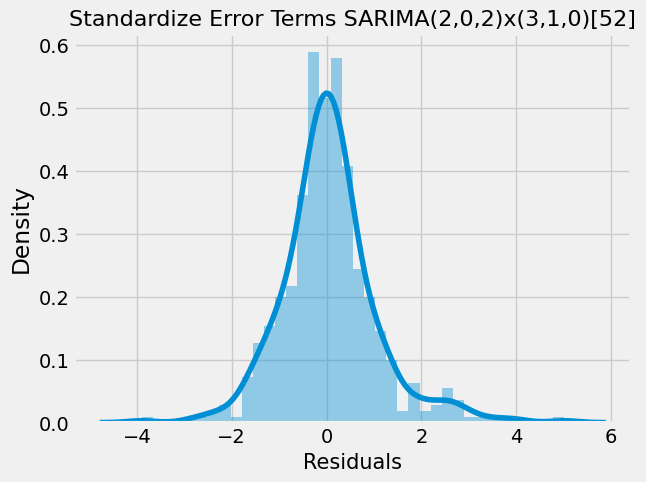

In [53]:
import seaborn as sns

# Standardize Residuals
#fig = plt.figure(figsize = (12, 4))
sqr_dev_mean = ((model_residuals - model_residuals.mean())**2).sum()
ar_resid_leverage = 1/model_residuals.count()+(model_residuals- model_residuals.mean())**2 / sqr_dev_mean

ar_std_residuals = model_residuals/ (model_residuals.std() * (1-ar_resid_leverage)**(1/2))

#ax = fig.add_subplot(1,2, inc+1)
sns.distplot(ar_std_residuals) # you may select the no. of bins
#sns.histplot(ar_std_residuals) # you may select the no. of bins
plt.title(f'Standardize Error Terms {model_name}', fontsize=16)           
plt.xlabel('Residuals', fontsize = 15) 
#plt.tight_layout()    
plt.show()